In [2]:
using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL, OrdinaryDiffEq,
      Plots
import ModelingToolkit: infimum, supremum
import ModelingToolkit as mdl 
#import ModelingToolkit: Interval as inter
@parameters t, σ_, β, ρ
@variables x(..), y(..), z(..)
Dt = Differential(t)
eqs = [Dt(x(t)) ~ σ_ * (y(t) - x(t)),
    Dt(y(t)) ~ x(t) * (ρ - z(t)) - y(t),
    Dt(z(t)) ~ x(t) * y(t) - β * z(t)]

bcs = [x(0) ~ 1.0, y(0) ~ 0.0, z(0) ~ 0.0]
domains = [t ∈ mdl.Interval(0.0, 1.0)]
dt = 0.01

0.01

In [13]:
using ComponentArrays
using DifferentialEquations
using Parameters: @unpack


tspan = (0.0, 20.0)


## Lorenz system
function lorenz!(D, u, p, t; f=0.0)
    @unpack σ, ρ, β = p
    @unpack x, y, z = u

    D.x = σ*(y - x)
    D.y = x*(ρ - z) - y - f
    D.z = x*y - β*z
    return nothing
end

lorenz_p = (σ=10.0, ρ=28.0, β=8/3)
lorenz_ic = ComponentArray(x=0.0, y=0.0, z=0.0)
lorenz_prob = ODEProblem(lorenz!, lorenz_ic, tspan, lorenz_p)


## Lotka-Volterra system
function lotka!(D, u, p, t; f=0.0)
    @unpack α, β, γ, δ = p
    @unpack x, y = u

    D.x =  α*x - β*x*y + f
    D.y = -γ*y + δ*x*y
    return nothing
end

lotka_p = (α=2/3, β=4/3, γ=1.0, δ=1.0)
lotka_ic = ComponentArray(x=1.0, y=1.0)
lotka_prob = ODEProblem(lotka!, lotka_ic, tspan, lotka_p)


## Composed Lorenz and Lotka-Volterra system
function composed!(D, u, p, t)
    c = p.c #coupling parameter
    @unpack lorenz, lotka = u

    lorenz!(D.lorenz, lorenz, p.lorenz, t, f=c*lotka.x)
    lotka!(D.lotka, lotka, p.lotka, t, f=c*lorenz.x)
    return nothing
end

comp_p = (lorenz=lorenz_p, lotka=lotka_p, c=0.01)
comp_ic = ComponentArray(lorenz=lorenz_ic, lotka=lotka_ic)
comp_prob = ODEProblem(composed!, comp_ic, tspan, comp_p)


## Solve problem
# We can solve the composed system...
comp_sol = solve(comp_prob)

# ...or we can unit test one of the component systems
lotka_sol = solve(lotka_prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 24-element Vector{Float64}:
  0.0
  0.11205673972702165
  0.36787621494945133
  0.7088665269830041
  1.1920199352223615
  1.7192644899240728
  2.3362229292484766
  3.083659227409378
  4.083069565166646
  5.300720634589403
  ⋮
 10.700442778648332
 11.747973094363843
 13.529632062520028
 14.775305873398702
 15.90375597924737
 16.897781802407383
 17.85855629576745
 18.980122006004194
 20.0
u: 24-element Vector{ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(x = 1, y = 2)}}}}:
 ComponentVector{Float64}(x = 1.0, y = 1.0)
 ComponentVector{Float64}(x = 0.9282072060356663, y = 0.995930454442075)
 ComponentVector{Float64}(x = 0.7878522100601244, y = 0.9597208036917968)
 ComponentVector{Float64}(x = 0.6514556626775214, y = 0.8708640043285939)
 ComponentVector{Float64}(x = 0.5392804798417309, y = 0.7138838689265949)
 ComponentVector{Float64}(x = 0.4920112

In [3]:
input_ = length(domains)
n = 8
chain1 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ),
                   Dense(n, 1))
chain2 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ),
                   Dense(n, 1))
chain3 = Lux.Chain(Dense(input_, n, Lux.σ), Dense(n, n, Lux.σ), Dense(n, n, Lux.σ),
                   Dense(n, 1))

Chain(
    layer_1 = Dense(1 => 8, sigmoid_fast),  # 16 parameters
    layer_2 = Dense(8 => 8, sigmoid_fast),  # 72 parameters
    layer_3 = Dense(8 => 8, sigmoid_fast),  # 72 parameters
    layer_4 = Dense(8 => 1),            # 9 parameters
)         # Total: 169 parameters,
          #        plus 0 states.

In [4]:
using ComponentArrays
function lorenz!(du, u, p, t)
    du[1] = 10.0 * (u[2] - u[1])
    du[2] = u[1] * (28.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - (8 / 3) * u[3]
end

u0 =  ComponentArray(x=0.0, y=0.0, z=0.0)#[1.0; 0.0; 0.0]
tspan = (0.0, 1.0)

"""
lorenz_p = (σ=10.0, ρ=28.0, β=8/3)
lorenz_ic = ComponentArray(x=0.0, y=0.0, z=0.0)
lorenz_prob = ODEProblem(lorenz!, lorenz_ic, tspan, lorenz_p)


"""

prob = ODEProblem(lorenz!, u0, tspan)
sol = solve(prob, Tsit5(), dt = 0.1)

ts = [infimum(d.domain):dt:supremum(d.domain) for d in domains][1]

function getData(sol)
    data = []
    us = hcat(sol(ts).u...)
    ts_ = hcat(sol(ts).t...)
    return [us, ts_]
end
data = getData(sol)
#data = ComponentArray(data)
(u_, t_) = data

len = length(data[2])

101

In [35]:
depvars = [:x, :y, :z]
#this loss function needs to be rewritten before being implemented. It is causing an error at runtime 
function additional_loss(phi, θ, p)
    return sum(sum(abs2, phi[i](t_, θ[depvars[i]]) .- u_[[i], :]) / len for i in 1:1:3)
end

additional_loss (generic function with 1 method)

this has the potential to be very valuable. for time series prediction we can do either system evolution and prediction with no data or inverse parameter estimtation. Then we can use our radii polynomial to prove that our previous answer is withen an interval that has the true equalibrium soluton to the system 

The first part is parameter estimation for the lorenz equations using a PINN

The second part is radiipolynomial that can be used to prove that the solution is in the interval of the true solution 

The main challenge is to choose A such that T is a contraction on some neighborhood of the unknown true solution.

This will be radii polynomial will also be extremely valuable for Pegasus. might also be good as an improvement on JEPPS

In [5]:
discretization = NeuralPDE.PhysicsInformedNN([chain1, chain2, chain3],
                                             NeuralPDE.GridTraining(dt), param_estim = true)#,
                                             #additional_loss = additional_loss)
@named pde_system = PDESystem(eqs, bcs, domains, [t], [x(t), y(t), z(t)], [σ_, ρ, β],
                              defaults = Dict([p .=> 1.0 for p in [σ_, ρ, β]]))
prob = NeuralPDE.discretize(pde_system, discretization)
callback = function (p, l)
    println("Current loss is: $l")
    return false
end

#15 (generic function with 1 method)

In [10]:

res = Optimization.solve(prob, BFGS(); callback = callback, maxiters =15)
p_ = res.u[(end - 2):end] # p_ = [9.93, 28.002, 2.667]

Current loss is: 17.29117839391586
Current loss is: 3.243367115255097
Current loss is: 2.322239285175196
Current loss is: 2.079447396898526


Current loss is: 0.8773516668858947
Current loss is: 0.6099340785265348
Current loss is: 0.45575246464500097
Current loss is: 0.43588916662111477
Current loss is: 0.43229159374038295
Current loss is: 0.4135506752136684
Current loss is: 0.3752149929584071
Current loss is: 0.29948491983002573


Current loss is: 0.2652718438871243
Current loss is: 0.21292004718689955
Current loss is: 0.17586305053012652
Current loss is: 0.10876875896870077


3-element Vector{Float64}:
  0.04105640737305433
 -0.1893734698667428
  1.78238625202638

In [11]:
depvars = [:x, :y, :z]

3-element Vector{Symbol}:
 :x
 :y
 :z

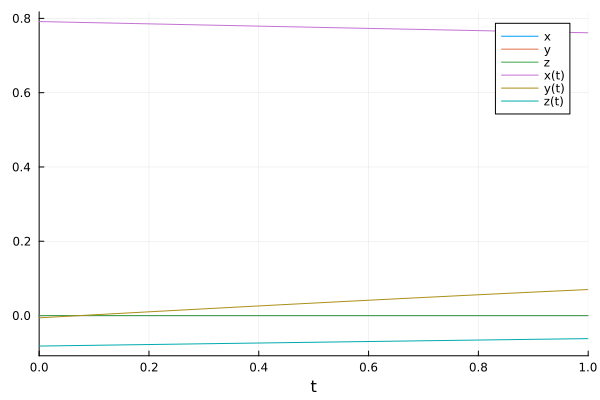

In [12]:
minimizers = [res.u.depvar[depvars[i]] for i in 1:3]
ts = [infimum(d.domain):(dt / 10):supremum(d.domain) for d in domains][1]
u_predict = [[discretization.phi[i]([t], minimizers[i])[1] for t in ts] for i in 1:3]
plot(sol)
plot!(ts, u_predict, label = ["x(t)" "y(t)" "z(t)"])

In [1]:
using RadiiPolynomial

function f!(f, u, σ, ρ, β)
    u₁, u₂, u₃ = eachcomponent(u)
    project!(component(f, 1), σ*(u₂ - u₁))
    project!(component(f, 2), u₁*(ρ - u₃) - u₂)
    project!(component(f, 3), u₁*u₂ - β*u₃)
    return f
end

function Df!(Df, u, σ, ρ, β)
    u₁, u₂, u₃ = eachcomponent(u)
    project!(component(Df, 1, 1), Multiplication(-σ*one(u₁)))
    project!(component(Df, 1, 2), Multiplication(σ*one(u₂)))
    project!(component(Df, 1, 3), Multiplication(zero(u₃)))
    project!(component(Df, 2, 1), Multiplication(ρ-u₃))
    project!(component(Df, 2, 2), Multiplication(-one(u₂)))
    project!(component(Df, 2, 3), Multiplication(-u₁))
    project!(component(Df, 3, 1), Multiplication(u₂))
    project!(component(Df, 3, 2), Multiplication(u₁))
    project!(component(Df, 3, 3), Multiplication(-β*one(u₃)))
    return Df
end

Df! (generic function with 1 method)

In [2]:
function F!(F, x, σ, ρ, β)
    γ, u = x[1], component(x, 2)

    F[1] =
        (sum(component(u, 1)) - 10.205222700615433) * 24.600655549587863 +
        (sum(component(u, 2)) - 11.899530531689562) * (-2.4927169722923335) +
        (sum(component(u, 3)) - 27.000586375896557) * 71.81142025024573

    project!(component(F, 2), γ * f!(component(F, 2), u, σ, ρ, β) - differentiate(u))

    return F
end

function DF!(DF, x, σ, ρ, β)
    γ, u = x[1], component(x, 2)

    DF .= 0

    component(component(DF, 1, 2), 1)[1,:] .= 24.600655549587863
    component(component(DF, 1, 2), 2)[1,:] .= -2.4927169722923335
    component(component(DF, 1, 2), 3)[1,:] .= 71.81142025024573

    f!(component(DF, 2, 1), u, σ, ρ, β)

    project!(component(DF, 2, 2), γ * Df!(component(DF, 2, 2), u, σ, ρ, β) - Derivative(1))

    return DF
end

DF! (generic function with 1 method)

In [3]:
σ, ρ, β = 10.0, 28.0, 8/3

n = 400

x̄ = Sequence(ParameterSpace() × Fourier(n, 1.0)^3, zeros(ComplexF64, 1+3*(2n+1)))
x̄[1] = 9.150971830259179/2π # γ, i.e. approximate inverse of the frequency
component(component(x̄, 2), 1)[0:14] =
    [6.25, -0.66 - 1.45im, 0.6 - 1.2im, 1.11 - 0.26im, 0.77 + 0.57im,
    0.08 + 0.76im, -0.35 + 0.45im, -0.39 + 0.13im, -0.37 - 0.0008im, -0.44 - 0.23im,
    -0.18 - 0.68im, 0.65 - 0.61im, 0.80 + 0.50im, -0.53 + 0.43im, 1.25 - 0.07im]
component(component(x̄, 2), 2)[0:14] =
    [6.25, -0.56 - 1.5im, 0.76 - 1.12im, 1.17 - 0.03im, 0.62 + 0.78im,
    -0.18 + 0.76im,-0.54 + 0.3im, -0.45 - 0.06im, -0.37 - 0.2im, -0.3 - 0.51im,
    0.29 - 0.8im, 1.11 - 0.13im, 0.4 + 1.16im, -0.91 - 0.05im, 1.31 + 1.13im]
component(component(x̄, 2), 3)[0:14] =
    [24.45, -0.22 - 1.62im, 1.13 - 0.83im, 1.2 + 0.53im, 0.14 + 1.28im,
    -1.03 + 0.75im, -1.14 - 0.52im, -0.08 - 1.21im, 0.98 - 0.57im, 0.79 + 0.59im,
    -0.27 + 0.69im, -0.34 - 0.23im, 0.57 + 0.22im, -1.23 + 1.02im, 0.75 - 2.69im]
component(component(x̄, 2), 1)[-14:-1] .= conj.(component(component(x̄, 2), 1)[14:-1:1])
component(component(x̄, 2), 2)[-14:-1] .= conj.(component(component(x̄, 2), 2)[14:-1:1])
component(component(x̄, 2), 3)[-14:-1] .= conj.(component(component(x̄, 2), 3)[14:-1:1])

newton!((F, DF, x) -> (F!(F, x, σ, ρ, β), DF!(DF, x, σ, ρ, β)), x̄)

# impose that x̄[1] is real and component(x̄, 2) are the coefficients of a real Fourier series
x̄[1] = real(x̄[1])
for i ∈ 1:3
    component(component(x̄, 2), i)[0] = real(component(component(x̄, 2), i)[0])
    component(component(x̄, 2), i)[-n:-1] .= conj.(component(component(x̄, 2), i)[n:-1:1])
end

Newton's method: Inf-norm, tol = 1.0e-12, maxiter = 15
      iteration        |F(x)|
-------------------------------------
          0          1.6564e+01

        |DF(x)\F(x)| = 8.9136e-01
          1          3.0854e+00

        |DF(x)\F(x)| = 4.5753e-01
          2          6.3059e-01

        |DF(x)\F(x)| = 3.0791e-01
          3          3.6251e-01

        |DF(x)\F(x)| = 3.8761e-02
          4          8.0576e-03

        |DF(x)\F(x)| = 1.5302e-03
          5          1.2868e-05

        |DF(x)\F(x)| = 1.7584e-05
          6          1.7964e-09

        |DF(x)\F(x)| = 2.5727e-10
          7          5.6804e-13

In [26]:
import LinearAlgebra: ⋅

In [4]:
#The computer-assisted proof may be implemented as follows:

ν = Interval(1.01)

X_F = ℓ¹(GeometricWeight(ν))
X_F³ = NormedCartesianSpace(X_F, ℓ∞())
X = NormedCartesianSpace((ℓ∞(), X_F³), ℓ∞())
R = 1e-8
σ_interval, ρ_interval, β_interval = Interval(10.0), Interval(28.0), 8.0/Interval(3.0)

x̄_interval = Sequence(ParameterSpace() × Fourier(n, Interval(1.0))^3, Interval.(coefficients(x̄)))
γ̄_interval = real(x̄_interval[1])
ū_interval = component(x̄_interval, 2)

F_interval = Sequence(ParameterSpace() × Fourier(2n, Interval(1.0))^3, similar(coefficients(x̄_interval), 1+3*(4n+1)))
F!(F_interval, x̄_interval, σ_interval, ρ_interval, β_interval)

tail_γ̄f_interval = copy(component(F_interval, 2))
for i ∈ 1:3
    component(tail_γ̄f_interval, i)[-n:n] .= 0
end

DF_interval = LinearOperator(space(F_interval), space(x̄_interval), similar(coefficients(x̄_interval), length(x̄_interval), length(F_interval)))
DF!(DF_interval, x̄_interval, σ_interval, ρ_interval, β_interval)

A = inv(mid.(project(DF_interval, space(x̄_interval), space(x̄_interval))))
bound_tail_A = inv(Interval(n+1))

# computation of the bounds

Y = norm(A * F_interval, X) + bound_tail_A * norm(tail_γ̄f_interval, X_F³)

Z₁ = opnorm(A * DF_interval - I, X) + bound_tail_A * norm(tail_γ̄f_interval, X_F³) / γ̄_interval +
    bound_tail_A * γ̄_interval * max(2σ_interval,
        1 + norm(component(ū_interval, 1), X_F) + norm(ρ_interval-component(ū_interval, 3), X_F),
        β_interval + norm(component(ū_interval, 1), X_F) + norm(component(ū_interval, 2), X_F))

Z₂ = (opnorm(Interval.(A), X) + bound_tail_A) * 2 * (γ̄_interval + R +
    max(2σ_interval,
        1 + ρ_interval + norm(component(ū_interval, 1), X_F) + norm(component(ū_interval, 3), X_F) + 2R,
        β_interval + norm(component(ū_interval, 1), X_F) + norm(component(ū_interval, 2), X_F) + 2R))

showfull(interval_of_existence(Y, Z₁, Z₂, R))

Interval(4.12166948164122e-9, 1.0e-8)